In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score, log_loss, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')

y = df['Heart_Disease']
X = df.drop('Heart_Disease', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, stratify=y)

# Transform Target column to 1's and 0's
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

num_cols = [
    'Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
    'Fruit_Consumption', 'Green_Vegetables_Consumption',
    'FriedPotato_Consumption'
]
ord_cols = ['General_Health', 'Checkup', 'Age_Category']
dum_cols = [
    'Exercise', 'Skin_Cancer', 'Depression', 'Arthritis', 'Other_Cancer',
    'Smoking_History', 'Sex', 'Diabetes'
]

health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
check = [
    'Never', '5 or more years ago', 'Within the past 5 years',
    'Within the past 2 years', 'Within the past year'
]
age = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
    '60-64', '65-69', '70-74', '75-79', '80+'
]

col_transformer = ColumnTransformer(transformers=[
    ('oe', OrdinalEncoder(categories=[health, check, age]), ord_cols),
    ('ohe', OneHotEncoder(), dum_cols)
],
                                    remainder="passthrough")



def data_prep(X_train, y_train, X_test, y_test, smote=True, scale=True):
    if smote & scale:
        pipe = ImPipeline(steps=[('ct',col_transformer),
                         ('ss', StandardScaler()),
                         ('sm', SMOTE(random_state=42))])
        X_train_resampled, y_train_resampled = pipe.fit_resample(X_train,y_train)
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=pipe.get_feature_names_out())
        X_test_scaled = pd.DataFrame(pipe[:-1].transform(X_test), columns=pipe.get_feature_names_out())
        return X_train_resampled_df, y_train_resampled, X_test_scaled, y_test
    elif smote:
        pipe = ImPipeline(steps=[('ct',col_transformer),
                         ('sm', SMOTE(random_state=42))])
        X_train_resamp, y_train_resamp = pipe.fit_resample(X_train,y_train)
        X_train_resamp_df = pd.DataFrame(X_train_resamp, columns=pipe.get_feature_names_out())
        X_test_transformed = pd.DataFrame(pipe[:-1].transform(X_test), columns=pipe.get_feature_names_out())
        return X_train_resamp_df, y_train_resamp, X_test_transformed, y_test
    elif scale:
        pipe = Pipeline(steps=[('col_transformer', col_transformer),
                               ('ss', StandardScaler())])
        pipe.fit(X_train)
        X_train_scaled = pd.DataFrame(pipe.transform(X_train), 
                                      columns=pipe.get_feature_names_out(),
                                      index=X_train.index)
        X_test_scaled = pd.DataFrame(pipe.transform(X_test), 
                                     columns=pipe.get_feature_names_out(),
                                     index= X_test.index)
        return X_train_scaled, y_train, X_test_scaled, y_test
    else:
        pipe = Pipeline(steps=[('col_transformer', col_transformer)])
        pipe.fit(X_train)
        X_train_transformed = pd.DataFrame(pipe.transform(X_train),
                                columns=pipe.get_feature_names_out(),
                                index=X_train.index)
        X_test_transformed = pd.DataFrame(pipe.transform(X_test),
                                columns=pipe.get_feature_names_out(),
                                index=X_test.index)
        return X_train_transformed, y_train, X_test_transformed, y_test

In [ ]:
X_tr, y_tr, X_ts, y_ts = data_prep(X_train, y_train, X_test, y_test, smote=False, scale=False)

xgb = XGBClassifier(random_state=12, tree_method = 'hist', )

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    xgb,
    param_grid=param_grid,
    cv=5,       # Number of cross-validation folds
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

In [11]:
X_tr, y_tr, X_ts, y_ts = data_prep(X_train, y_train, X_test, y_test, smote=False, scale=False)

xgb = XGBClassifier(random_state=12, tree_method = 'hist',scale_pos_weight=11.368645877829987)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
}

# Create GridSearchCV object
gs = GridSearchCV(
    xgb,
    param_grid=param_grid,
    cv=5,       # Number of cross-validation folds
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the grid search to your data
search = gs.fit(X_tr, y_tr)
search.best_score_
# 4h 2m 14s
# 0.8361495627477165
# {'colsample_bytree': 0.8,
#  'gamma': 0.1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'min_child_weight': 1,
#  'n_estimators': 200,
#  'subsample': 0.8}


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, m

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, subsa

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsamp

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsamp

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsam

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; 

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; 

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.8; 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   4.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total 

[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   7.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total t

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  10.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  18.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total t

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   7.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.9; total time= 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   9.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.9; total time=  

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   6.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   6.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   6.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  11.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   6.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   7.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=  10.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsamp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   9.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  10.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  10.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsamp

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9; total time=  10.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  15.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.9; total time=  10.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=  11.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.9

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   8.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   5.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  13.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   5.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   8.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.9; total time=  12.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  13.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8;

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   5.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   6.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.9; 

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  11.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   4.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  12.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   5.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=50, subsampl

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  10.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsamp

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   2.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   6.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   1.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   7.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   8.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   6.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.9;

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   8.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   3.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8;

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   4.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   6.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.9;

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   7.8s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  11.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   8.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9;

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   7.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  10.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   3.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  10.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=  10.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  14.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  14.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   5.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  10.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  14.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total 

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   5.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   5.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.9; total time=  10.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  14.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.8; total 

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=  10.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.9; total time=  10.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  14.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  10.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   9.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.9; tota

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.9; total time=   2.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, subsample=0.9; total time=   8.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   2.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   4.4s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   8.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  11.7s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=  11.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time= 

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.8; total time=21.0min
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  25.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=  13.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  19.6s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0.9; total time=  

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  12.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9; total time=  12.5s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  20.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   6.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  16.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time= 

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   7.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  12.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  19.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  18.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.9; total time=  17.2s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsa

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.8; total time=  12.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9; total time=  13.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  17.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   6.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  17.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsam

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.9; total time=  12.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  18.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   5.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   9.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsamp

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  17.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  25.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   5.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   8.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsampl

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=0.9; total time=   5.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time= 4.0min
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time= 4.6min
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   3.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time=  39.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=50, subsample=0.9; total time= 7.4min
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, subsampl

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=200, subsample=0.9; total time=   9.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, subsample=0.9; total time=  13.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   4.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.9; total time=   4.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   6.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, subsample=0

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=50, subsample=0.9; total time=   2.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   3.6s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   5.9s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.9; total time=   5.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   8.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=50, subsample=0.9; 

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.8; total time=  10.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.8; total time=  15.8s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=300, subsample=0.9; total time=  13.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=100, subsample=0.9; total time=   5.3s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   9.4s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.8; total time=  13.5s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=50, subsample=0.8

0.8361495627477165

In [6]:
212912/18728

11.368645877829987

In [14]:
rfc_pipe = Pipeline(steps=[('ct', col_transformer),
                           ('rfc', RandomForestClassifier(random_state=12, class_weight='balanced'))])
param_dist = {
    'rfc__n_estimators': range(50, 1000, 50),          # Number of trees in the forest
    'rfc__max_depth': [None] + list(range(5, 31, 5)),  # Maximum depth of trees
    'rfc__min_samples_split': range(2, 21),           # Minimum number of samples required to split an internal node
    'rfc__min_samples_leaf': range(1, 21),            # Minimum number of samples required to be at a leaf node
    'rfc__max_features': ['sqrt', 'log2'],    # Number of features to consider at each split
    'rfc__bootstrap': [True, False],                  # Whether to use bootstrap samples
    'rfc__criterion': ['gini', 'entropy']            # Function to measure the quality of a split
}

rs = RandomizedSearchCV(
    rfc_pipe,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,       # Number of cross-validation folds
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,  # Use all available CPU cores
    random_state=12
)

# Fit the randomized search to your data
search = rs.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)
# 4h 9m 12s,
# 0.8326532401510953
# {'rfc__n_estimators': 850, 
#  'rfc__min_samples_split': 6, 
#  'rfc__min_samples_leaf': 19, 
#  'rfc__max_features': 'sqrt', 
#  'rfc__max_depth': 15, 
#  'rfc__criterion': 'gini', 
#  'rfc__bootstrap': True}


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__min_samples_leaf=12, rfc__min_samples_split=10, rfc__n_estimators=50; total time=  29.6s
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=12, rfc__min_samples_split=7, rfc__n_estimators=600; total time= 3.6min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=2, rfc__min_samples_split=3, rfc__n_estimators=150; total time=  50.5s
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=11, rfc__min_samples_split=18, rfc__n_estimators=500; total time= 7.6min
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=19, rfc__min_samples_split=5, rfc__n_estimators=100; total time

[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=15, rfc__max_features=log2, rfc__min_samples_leaf=8, rfc__min_samples_split=9, rfc__n_estimators=350; total time= 3.9min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=12, rfc__min_samples_split=7, rfc__n_estimators=600; total time= 3.5min
[CV] END rfc__bootstrap=False, rfc__criterion=entropy, rfc__max_depth=30, rfc__max_features=sqrt, rfc__min_samples_leaf=4, rfc__min_samples_split=9, rfc__n_estimators=600; total time= 9.4min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__min_samples_leaf=12, rfc__min_samples_split=9, rfc__n_estimators=450; total time= 4.8min
[CV] END rfc__bootstrap=True, rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=log2, rfc__min_samples_leaf=1, rfc__min_samples_split=11, rfc__n_estimators=950; total time= 5.8min
[CV] END rfc__bootstrap=False, rfc__criterion=entropy, 

[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__min_samples_leaf=12, rfc__min_samples_split=10, rfc__n_estimators=50; total time=  29.4s
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=15, rfc__max_features=log2, rfc__min_samples_leaf=8, rfc__min_samples_split=9, rfc__n_estimators=350; total time= 3.9min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=2, rfc__min_samples_split=3, rfc__n_estimators=150; total time=  51.8s
[CV] END rfc__bootstrap=False, rfc__criterion=entropy, rfc__max_depth=30, rfc__max_features=sqrt, rfc__min_samples_leaf=4, rfc__min_samples_split=9, rfc__n_estimators=600; total time= 9.7min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=20, rfc__max_features=sqrt, rfc__min_samples_leaf=12, rfc__min_samples_split=9, rfc__n_estimators=450; total time= 3.5min
[CV] END rfc__bootstrap=True, rfc__criterion=entropy, rfc

[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=sqrt, rfc__min_samples_leaf=12, rfc__min_samples_split=10, rfc__n_estimators=50; total time=  29.5s
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=12, rfc__min_samples_split=7, rfc__n_estimators=600; total time= 3.6min
[CV] END rfc__bootstrap=True, rfc__criterion=gini, rfc__max_depth=10, rfc__max_features=log2, rfc__min_samples_leaf=2, rfc__min_samples_split=3, rfc__n_estimators=150; total time=  50.3s
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=11, rfc__min_samples_split=18, rfc__n_estimators=500; total time= 7.6min
[CV] END rfc__bootstrap=False, rfc__criterion=gini, rfc__max_depth=None, rfc__max_features=sqrt, rfc__min_samples_leaf=19, rfc__min_samples_split=5, rfc__n_estimators=100; total time= 1.3min
[CV] END rfc__bootstrap=False, rfc__criterion=gini, r

0.8326532401510953
{'rfc__n_estimators': 850, 'rfc__min_samples_split': 6, 'rfc__min_samples_leaf': 19, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 15, 'rfc__criterion': 'gini', 'rfc__bootstrap': True}


In [30]:
clf_pipe = Pipeline(steps=[('ct', col_transformer),
                          ('xgb',XGBClassifier(n_estimators=800,
                                               max_depth = 4,
                                               learning_rate = 0.01,min_child_weight= 2,
                                               subsample=0.8, 
                                               colsample_bytree=0.8, 
                                               gamma=0.1, 
                                               tree_method= 'hist',
                                               random_state=12,
                                               scale_pos_weight=11.368645877829987))])

                          
clf_pipe.fit(X_train, y_train)

y_preds = clf_pipe.predict(X_test)




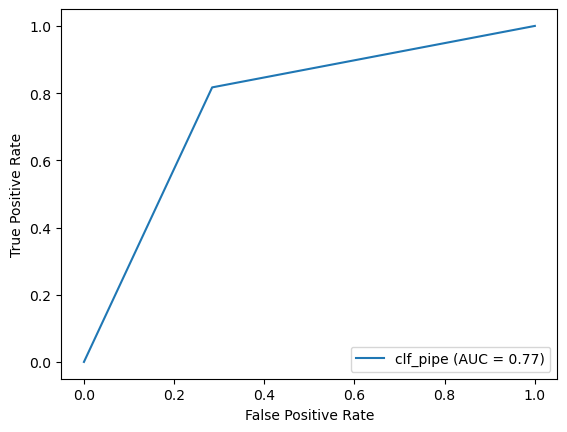

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='clf_pipe')
display.plot()
plt.show();

In [32]:
thresholds

array([2, 1, 0])

In [37]:
confusion_matrix(y_test, y_preds, normalize='true')

array([[0.71565851, 0.28434149],
       [0.18292488, 0.81707512]])

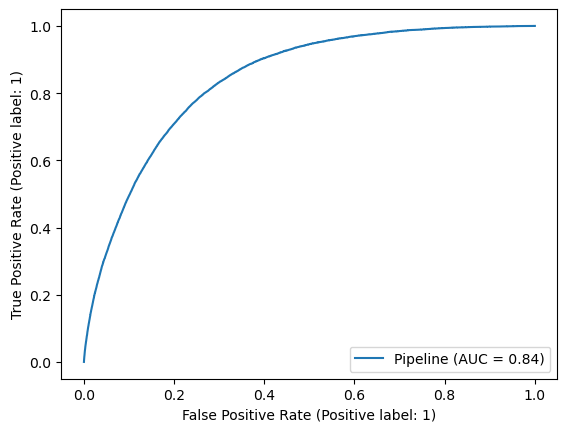

In [38]:
RocCurveDisplay.from_estimator(clf_pipe, X_train, y_train)

In [47]:
roc_curve(y_test,y_preds)

(array([0.        , 0.28434149, 1.        ]),
 array([0.        , 0.81707512, 1.        ]),
 array([2, 1, 0]))

In [ ]:
pipe = ImPipeline(steps= [('ct',col_transformer ),
                         ('ad', ADASYN(random_state=12)),
                         ()])